In [1]:
import json
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import re 
#import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
#plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from PIL import Image
import matplotlib.font_manager as fm
from wordcloud import WordCloud,ImageColorGenerator
from snownlp import SnowNLP
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns


# Motivation
We aim to provide meaningful business suggestions for restaurants with relatively low scores. Since in such case, our suggestions would be the most beneficial comparing providing suggestions to business that already attained a high score.

In the meanwhile, we target restaurants with as many reviews as possible. First, more views give us more information to analyze and make us easy to draw various conclusions. Second, a restarurant with lots of reviews but still holds a low scre is a really special and interesting situation. 


# Goals
So based on our Motivation, our goal is to provide suggestions for business owner to improve their ratings based on Yelp reviews and business datasets.

**A. Summarize present comments/feedbacks of customers in terms of following aspects**
1. Food comments. What food does customers like or dislike?
2. Business Attributes e.g. locations and views
3. Price
4. Service

**B. Give suggestions to business owner to improve their ratings**
1. Improve their sevices
2. Improve their food quality 
3. Etc

# Data Preparation
Based on above two rules in our Motivation section, we preprocess our raw data. Our target is to choose a business with <3 stars and with many views as possible.

In [2]:
business = []
for line in open('../data/business.json', 'r'):
    business.append(json.loads(line))
df = pd.DataFrame(business)
df_sort=df.sort_values('review_count',ascending=False).head(50)
df_sort.loc[df_sort['stars']<3,:]
#df.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
118766,Z5Oc3lC-NAhbmfVfRnwSzQ,The OASIS on Lake Travis,6550 Comanche Trl,Austin,TX,78732,30.405899,-97.873952,2.5,2532,1,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Wedding Planning, Tex-Mex, Event Planning & Se...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-16:0',..."


We select **"The OASIS on Lake Travis" in Austin, TX with 2.5 stars and 2532 reviews** as our target business.

Then we select and load the corresponding reviwes and tips of our target business by its business ID.

We have in total 2578 reviews and 260 tips for our target business.

In [3]:
target_review = []
for line in open('../data/review.json', 'r'):
    result=json.loads(line)
    if result["business_id"]=="Z5Oc3lC-NAhbmfVfRnwSzQ":
        target_review.append(result)
    else:continue
        
target_tip = []
for line in open('../data/tip.json', 'r'):
    result=json.loads(line)
    if result["business_id"]=="Z5Oc3lC-NAhbmfVfRnwSzQ":
        target_tip.append(result)
    else:continue

  

In [4]:
print("number of reviews of target business:",len(target_review))
print("number of tips of target business:",len(target_tip))

number of reviews of target business: 2578
number of tips of target business: 260


In [5]:
review_df=pd.DataFrame(target_review)
review_df.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,PpiVsfKBuHHrtk3v9GqStw,8wHfZSoU-jo3TwegBg_aPg,Z5Oc3lC-NAhbmfVfRnwSzQ,3.0,0,0,0,My family and I decided to have a late lunch a...,2017-02-19 07:02:42
1,jMTYIk4zHU3Rr5AYX5LBiw,J9mTwl4sh0HT_KeS-bd2YA,Z5Oc3lC-NAhbmfVfRnwSzQ,1.0,1,0,0,I wanted to like this place based on the stunn...,2017-07-08 17:25:57
2,H5LxoZBkrSA4VntAtNzv0w,DTGOyVfBNUgXuaIoM-rwmw,Z5Oc3lC-NAhbmfVfRnwSzQ,2.0,2,1,0,"The food was boring, flavorless, and uncreativ...",2012-06-26 02:16:30


In [6]:
tip_df=pd.DataFrame(target_tip)
tip_df.head(3)

,user_id,business_id,text,date,compliment_count
0,Ult681KMSYmgJZBGYlhFwg,Z5Oc3lC-NAhbmfVfRnwSzQ,They now have more than one wine option (thank...,2012-03-17 00:35:18,0
1,0WkwmWIfIzE83EwHIo0qWw,Z5Oc3lC-NAhbmfVfRnwSzQ,Spectacular views but slow service and mediocr...,2015-09-01 03:43:06,0
2,abkz8s2Hr7mLCwdKUxoSTA,Z5Oc3lC-NAhbmfVfRnwSzQ,Sure its got spectacular views but thats about...,2017-04-21 23:53:29,0


# Data Preview

Text(0, 0.5, 'Count')

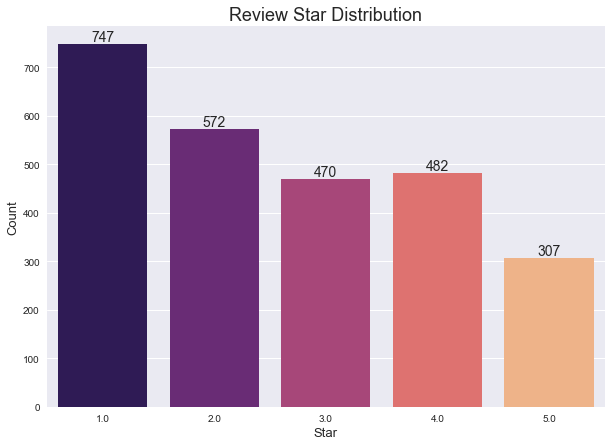

In [7]:
#import matplotlib.pyplot as plt
plt.style.use(['seaborn'])
review_df_star=review_df.groupby('stars').count().reset_index().iloc[:,0:2]
review_df_star.columns = ['stars', 'count']
fig, ax = plt.subplots(figsize=(10,7))
p=sns.barplot(x=review_df_star['stars'],y=review_df_star['count'],palette="magma")
a=ax.bar_label(p.containers[0],fontsize=14)

plt.title("Review Star Distribution",fontsize=18)
plt.xlabel('Star', fontsize=13)
plt.ylabel("Count", fontsize=13)

max length of reviews: 4977
min length of reviews: 50


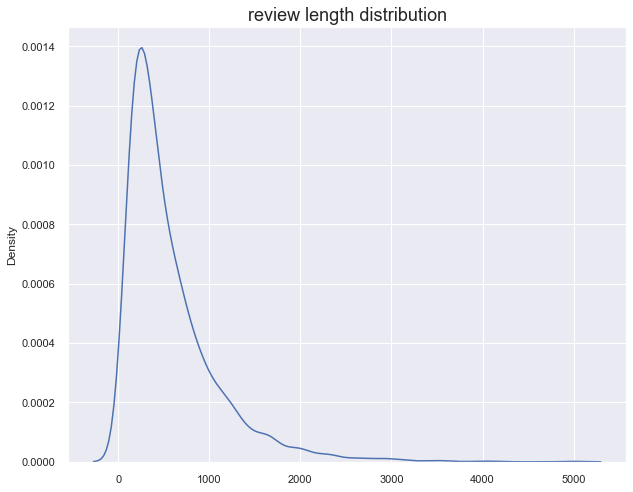

In [8]:
Len=[]
for x in review_df['text']:
    Len.append(len(x))
sns.set_theme()
sns.set(rc={'figure.figsize':(10,8)})

sns.kdeplot(Len)
plt.title("review length distribution",fontsize=18)
print("max length of reviews:",max(Len))
print("min length of reviews:",min(Len))

In [9]:
import colorama
from colorama import Fore

print(Fore.RED +"shortest review:")
print("score:",review_df['stars'][np.argmin(Len)])
print(Fore.BLACK+review_df['text'][np.argmin(Len)])

print("\n")
print(Fore.RED +"longest review:")
print("score:",review_df['stars'][np.argmax(Len)])
print(Fore.BLACK+review_df['text'][np.argmax(Len)])


shortest review:
score: 2.0
Best view, OKest food, and worst service in Texas.


longest review:
score: 2.0
I've changed my rating from 2 to 3, and back again--twice. My conflict matches the inharmonious nature of this place perfectly. Allow me to explain. (Grab a drink first, I have a lot to say about this place.) 

My daughter is a new resident of Austin and she wanted to spend her birthday somewhere special, interesting, unusual. The Oasis on Lake Travis is a well-known tourist attraction, so it fit the bill. Reviews are so mixed, however, that before you even arrive, you already have a sense of apprehension. We told ourselves that we were coming for the view (particularly at sunset) that everyone raves about. Let's start there. 

Lake Travis is a man-made lake created by the construction of a dam. It is vast (65 miles) and from The Oasis' position high up on a cliff, you get a very nice panoramic view. Yes, I said "very nice." Admittedly, it was somewhat cloudy on the day we visite

# Data Preprocess

For text data, usually we preprocess them in following ways.

1. tokenize: split sentence into words by whitespace or other indicators

2. remove stopwords: remove non-informative words, e.g. the, a, an

3. stem words: reduce a word to its word stem, e.g. swim, swam, swum, swimming, swims to swim

### word frequency

In [10]:
#default
from nltk.tokenize import word_tokenize 
stemmer = SnowballStemmer("english")
stopwords = nltk.corpus.stopwords.words('english')


#1. tokenize
tokenized_sents = [word_tokenize(i.lower()) for i in review_df["text"]]
tokenized_words = [item for sublist in tokenized_sents for item in sublist]

#2. remove stopwords

meaningful_words = [w for w in tokenized_words if not w in stopwords]  

#3. stem words
stem_words=[stemmer.stem(w) for w in meaningful_words]

In [11]:
counts = {} 
for word in meaningful_words:  
    if len(word) == 1:  
        continue  
    else:  
        counts[word] = counts.get(word,0) + 1
items = list(counts.items())

items.sort(key=lambda x:x[1], reverse=True)
for i in range(15): #
    word, count = items[i]  
    print ("{:<10}{:>7}".format(word, count))

food         3519
view         2589
n't          2321
place        1585
's           1480
good         1400
service      1346
great        1238
oasis        1014
go           1004
get           991
us            970
would         945
drinks        908
time          907


In [12]:
from nltk.tokenize import TweetTokenizer

stopwords.append(['.',',','us','...','!','x','x x x x','x x x x x'])
keep_words = ['below','above','under','more','most','only','so','than','too','very']
stopwords = [word for word in stopwords if word not in keep_words]

tknzr = TweetTokenizer()#different tokenizer
corpus_review=' '.join(review_df['text']).lower()
corpus_review=corpus_review.replace(".", "")
corpus_review=corpus_review.replace("!", "")
corpus_review=corpus_review.replace("x x x x", "")
corpus_review=corpus_review.replace("x x x x x", "")
corpus_tokens = tknzr.tokenize(corpus_review)
tokenized_words = tknzr.tokenize(corpus_review)

#1. tokenize
#tokenized_sents = [tknzr.tokenize(i.lower()) for i in review_df["text"]]
#tokenized_words = [item for sublist in tokenized_sents for item in sublist]

#2. remove stopwords

meaningful_words = [w for w in tokenized_words if not w in stopwords]  

#3. stem words
stem_words=[stemmer.stem(w) for w in meaningful_words]
#tknzr.tokenize("The code didn't work!")

In [13]:
counts = {} 
for word in meaningful_words:  
    if len(word) == 1:  
        continue  
    else:  
        counts[word] = counts.get(word,0) + 1
items = list(counts.items())

items.sort(key=lambda x:x[1], reverse=True)
for i in range(10): #
    word, count = items[i]  
    print ("{:<10}{:>7}".format(word, count))

food         3532
view         2577
place        1585
so           1516
good         1391
service      1348
great        1232
oasis        1007
go           1004
get           988


In [14]:
def get_word_freq(string,num_word=5):
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.append(['.',',','us','...','!','x','x x x x','x x x x x'])
    keep_words = ['below','above','under','more','most','only','so','than','too','very']
    stopwords = [word for word in stopwords if word not in keep_words]

    tknzr = TweetTokenizer()#different tokenizer
    corpus_review=string
    corpus_review=corpus_review.replace(".", "")
    corpus_review=corpus_review.replace("!", "")
    corpus_review=corpus_review.replace("x x x x", "")
    corpus_review=corpus_review.replace("x x x x x", "")
    corpus_tokens = tknzr.tokenize(corpus_review)
    tokenized_words = tknzr.tokenize(corpus_review)
    
    meaningful_words = [w for w in tokenized_words if w not in stopwords]  

    stem_words=[stemmer.stem(w) for w in meaningful_words]

    
    counts = {} 
    for word in meaningful_words:  
        if len(word) == 1:  
            continue  
        else:  
            counts[word] = counts.get(word,0) + 1
    items = list(counts.items())

    items.sort(key=lambda x:x[1], reverse=True)
    for i in range(num_word): #
        word, count = items[i]  
        print ("{:<10}{:>7}".format(word, count))
    
    return items

In [15]:
string=str(' '.join(list(review_df.loc[review_df['stars']==5,]['text']))).lower()
result=get_word_freq(string,num_word=8)

food          281
great         244
view          233
place         157
good          151
so            127
amazing       122
oasis         120


In [16]:
string=str(' '.join(list(review_df.loc[review_df['stars']==1,]['text']))).lower()
result=get_word_freq(string,num_word=8)

food         1104
view          622
service       519
so            492
us            492
place         447
get           405
table         400


### Wordcloud of reviews

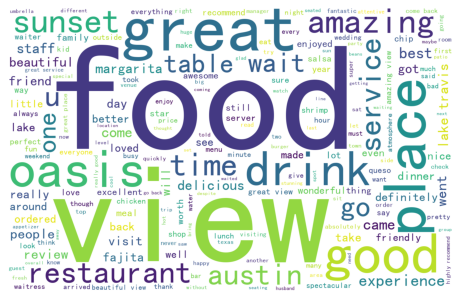

In [144]:
#bg=np.array(Image.open("/Users/app/代码/文本挖掘/国徽.jpg"))
wordcloud = WordCloud(font_path="/Users/app/Downloads/SimHei.ttf",
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10,               #设置图片的边缘  
        ).generate(str(' '.join(list(review_df.loc[review_df['stars']==5,]['text']))).lower())
#my_font=fm.FontProperties(fname='/Users/app/Downloads/SimHei.ttf')
#image_colors=ImageColorGenerator(bg)
# 绘制图片
plt.imshow(wordcloud)
# 消除坐标轴
plt.axis("off")
# 展示图片
plt.show()
#wordcloud.to_file('人民的名义词云.png')
#文段词云

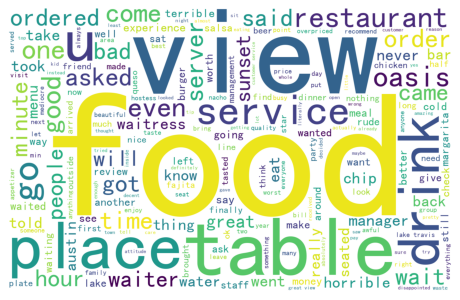

In [145]:
wordcloud = WordCloud(font_path="/Users/app/Downloads/SimHei.ttf",
        background_color="white", #设置背景为白色，默认为黑色
        width=1500,              #设置图片的宽度
        height=960,              #设置图片的高度
        margin=10,               #设置图片的边缘  
        ).generate(str(' '.join(list(review_df.loc[review_df['stars']==1,]['text']))).lower())
#my_font=fm.FontProperties(fname='/Users/app/Downloads/SimHei.ttf')
#image_colors=ImageColorGenerator(bg)
# 绘制图片
plt.imshow(wordcloud)
# 消除坐标轴
plt.axis("off")
# 展示图片
plt.show()
#wordcloud.to_fil

### Important grams

In [100]:


#create ngrams from n=2 to 5
bigrams = list(nltk.ngrams(corpus_tokens,2))
trigrams = list(nltk.ngrams(corpus_tokens,3))
fourgrams = list(nltk.ngrams(corpus_tokens,4))
fivegrams = list(nltk.ngrams(corpus_tokens,5))

In [123]:
#if you change this to zero you will only get the user chosen ngrams
n_most_common=3 #how many of the most common n-grams do you want.

fdist_bigrams = nltk.FreqDist(bigrams).most_common(n_most_common) #n most common bigrams
fdist_trigrams = nltk.FreqDist(trigrams).most_common(n_most_common) #n most common trigrams
fdist_fourgrams = nltk.FreqDist(fourgrams).most_common(n_most_common) #n most common four grams
fdist_fivegrams = nltk.FreqDist(fivegrams).most_common(n_most_common) #n most common five grams

#concat the ngrams together
Gram=[fdist_bigrams,fdist_trigrams,fdist_fourgrams,fdist_fivegrams]
gram=[];count=[]
for x in Gram:
    for y in x:
        gram.append(' '.join(y[0]))
        count.append(y[1])
pd.DataFrame({'gram':gram,"count":count})


,gram,count
0,the food,1641
1,the view,1492
2,for the,1135
3,the food is,438
4,the view is,374
5,for the view,347
6,view of lake travis,88
7,for the view and,74
8,view of the lake,66
9,an hour and a half,30


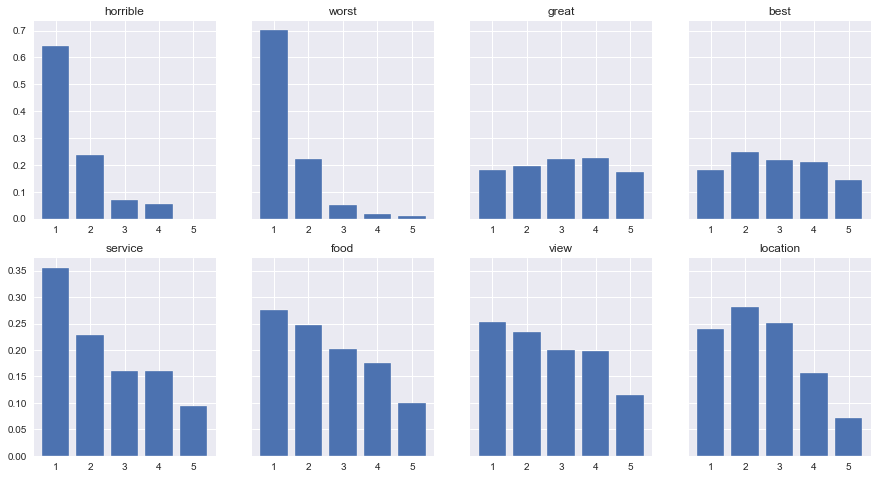

In [182]:
fig, axes = plt.subplots(ncols=4, nrows=2,figsize=(15,8),sharex='row',sharey='row')
W=['horrible','worst','great','best','service','food','view','location']
for i, ax in zip(range(8), axes.flat):
    
    Score=[]
    for index, row in review_df.iterrows():
        #print(row['c1'], row['c2'])
        if W[i] in row['text'].lower():
            Score.append(row["stars"])
    value=np.unique(Score,return_counts=True)[0]
    count=np.unique(Score,return_counts=True)[1]   
    count=count/sum(count)        
    ax.bar(value,count)
    ax.set_title(f"{W[i]}")
    #ax.set_title(f"{N[ID]} nodes X vs X_hat")

## Method

1. attribute, 一到两个，hypothesis testing, Anova 比较 star significant difference
2. food（价格, ）, service（多加点桌，减少等待时长，waiting time）, view（继续保持）



1. 对一个business分类刻画，e.g. service, food, view, 
2. Combined with menu
3. business attributes Anova 比较 star significant difference

4. weight by user review number #future planning, see difference, accurate results
5. weight by review words


6. Compare, review frequency, categories不同点，location，邮编相近，
7. business attributes 相同的，类似的，比较review frequency
8. 词的关联性匹配，steak delicious，星状图  
9. scaled with personal stars

10. consider time and sapce aspect

## Load Related Review and Tip Data

In [9]:
review_df_star=review_df.groupby('stars').count().reset_index().iloc[:,0:2]
review_df_star.columns = ['stars', 'count']
fig = px.bar(review_df_star, x='stars', y='count', text='count',color='count',color_continuous_scale="Rdbu")
fig.update_layout(
    title={
        'text': "Review Star Distribution",
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

import plotly.io as pio
pio.renderers.default='notebook'

fig.update_layout(title_font_size=20,)
fig.show()


NameError: name 'px' is not defined

In [130]:
target_review[0]

{'review_id': 'PpiVsfKBuHHrtk3v9GqStw',
 'user_id': '8wHfZSoU-jo3TwegBg_aPg',
 'business_id': 'Z5Oc3lC-NAhbmfVfRnwSzQ',
 'stars': 3.0,
 'useful': 0,
 'funny': 0,
 'cool': 0,
 'text': 'My family and I decided to have a late lunch at this wonderful spot on Lake Travis. The views of the Lake are great, but the food is just average for food in Austin. It was tasty enough, but nothing special. Most of my party had their fish tacos. The pineapple in the tacos was good, but the beans and guacamole was just average. I had the beef enchiladas. They had a little kick in the taste which I did like, but otherwise, they were unremarkable. Our waiter was trying to be helpful, but was slow to refill the beverages and restock the chips and salsa (also average, but not stale). There can be a bit of a wait to get in, but they are pretty efficient at getting you in queue so your party can wait in the bar, explore the gift shop or explore other options (like the onsite brewhouse or coffee shop). I think i

In [131]:
review_text=[]
for x in target_review:
    review_text.append(x['text'])

In [43]:
target_tip = []
for line in open('../data/tip.json', 'r'):
    result=json.loads(line)
    if result["business_id"]=="Z5Oc3lC-NAhbmfVfRnwSzQ":
        target_tip.append(result)
    else:continue
    

In [44]:
len(target_tip)

260

In [59]:
target_tip[0]

{'user_id': 'Ult681KMSYmgJZBGYlhFwg',
 'business_id': 'Z5Oc3lC-NAhbmfVfRnwSzQ',
 'text': 'They now have more than one wine option (thank goodness).',
 'date': '2012-03-17 00:35:18',
 'compliment_count': 0}

## Text Data Preprocess

## Atributes

### visualization
1. Barplot, stars distribution
2. Wordcloud
3. Text Sentiment
4. Topic?

In [96]:
review_star=[]
for x in target_review:
    review_star.append(x['stars'])
review_df_star

In [84]:
review_df_star=review_df.groupby('stars').count().reset_index().iloc[:,0:2]
#review_df_star=review_df_star.rename(columns={"User": "Users"})
review_df_star.columns = ['stars', 'count']

#data_canada = data[data.country == 'Canada']
fig = px.bar(review_df_star, x='stars', y='count', text='count',color='count',color_continuous_scale="Rdbu")
             #color='count', height=400,)
#fig.update_traces(textposition='outside')
fig.show()
#Magma

### Word Frequency

In [132]:
from nltk.tokenize import word_tokenize 
#1. tokenize
tokenized_sents = [word_tokenize(i.lower()) for i in review_text]
tokenized_words = [item for sublist in tokenized_sents for item in sublist]

#2. remove stopwords
#stops = set(stopwords.words("english")) 
meaningful_words = [w for w in tokenized_words if not w in stopwords]  

#3. stem words
stem_words=[stemmer.stem(w) for w in meaningful_words]

In [198]:
#text sentiment情感
#topic modeling主题

In [133]:
counts = {} 
for word in stem_words:  
    #不在停用词表中  
    if word not in stopwords:  
        #不统计字数为一的词  
        if len(word) == 1:  
            continue  
        else:  
            counts[word] = counts.get(word,0) + 1 #dict.get寻找字典中是否有key为word如果有返回value，无返回0
items = list(counts.items())

In [134]:
items.sort(key=lambda x:x[1], reverse=True)#除去姓名后的高频词汇
for i in range(10): #
    word, count = items[i]  
    print ("{:<10}{:>7}".format(word, count))

food         3531
view         3120
n't          2321
place        1727
's           1480
good         1414
go           1384
servic       1355
drink        1312
great        1247


In [144]:

def token_stopword_stem(text):
    #1. tokenize
    tokenized_sents = [word_tokenize(i.lower()) for i in text]
    tokenized_words = [item for sublist in tokenized_sents for item in sublist]

    #2. remove stopwords
    #stops = set(stopwords.words("english")) 
    meaningful_words = [w for w in tokenized_words if not w in stopwords]  

    #3. stem words
    stem_words=[stemmer.stem(w) for w in meaningful_words]

    counts = {} 
    for word in stem_words:  
        #不在停用词表中  
        if word not in stopwords:  
            #不统计字数为一的词  
            if len(word) == 1:  
                continue  
            else:  
                counts[word] = counts.get(word,0) + 1 #dict.get寻找字典中是否有key为word如果有返回value，无返回0
    items = list(counts.items())

    items.sort(key=lambda x:x[1], reverse=True)#除去姓名后的高频词汇
    for i in range(5): #
        word, count = items[i]  
        print ("{:<10}{:>7}".format(word, count))

In [145]:
review_text_1=[]
for x in review_df.loc[review_df['stars']==1,]['text']:
    review_text_1.append(x)

In [146]:
# Words Freq for 1 star
token_stopword_stem(text=review_text_1)

food         1105
n't           947
view          718
tabl          531
servic        526


In [147]:
review_text_5=[]
for x in review_df.loc[review_df['stars']==5,]['text']:
    review_text_5.append(x)

# Words Freq for 5 star
token_stopword_stem(text=review_text_5)

view          307
food          279
great         247
place         173
good          152


### Rating contain certain words

<BarContainer object of 5 artists>

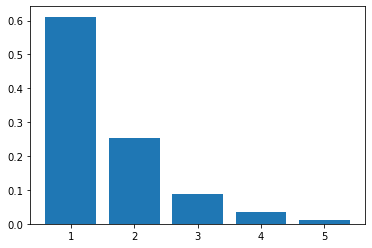

In [200]:
Score=[]
for index, row in review_df.iterrows():
    #print(row['c1'], row['c2'])
    if 'terrible' in row['text'].lower():
        Score.append(row["stars"])
value=np.unique(Score,return_counts=True)[0]
count=np.unique(Score,return_counts=True)[1]   
count=count/sum(count)        
plt.bar(value,count)

In [171]:
d = {'star': value, 'count': count}
df=pd.DataFrame(d)

fig = px.bar(df, x='star', y='count', text='count',color='count',color_continuous_scale="Rdbu")
             #color='count', height=400,)
#fig.update_traces(textposition='outside')
fig.show()
#sns.barplot(value,count)

In [49]:
#for x,y in zip(np.unique(bus_madison,return_counts=True)[0],np.unique(bus_madison,return_counts=True)[1]):
    #if y>1000:
        #print(x,y)

In [6]:
covid[covid_id.index("WSg1mYGqc6-5L2Pod7GWfg")]

{'business_id': 'WSg1mYGqc6-5L2Pod7GWfg',
 'highlights': 'FALSE',
 'delivery or takeout': 'FALSE',
 'Grubhub enabled': 'FALSE',
 'Call To Action enabled': 'TRUE',
 'Request a Quote Enabled': 'FALSE',
 'Covid Banner': 'FALSE',
 'Temporary Closed Until': 'FALSE',
 'Virtual Services Offered': 'offers_virtual_consultations'}

In [4]:
list(set(bus_id) & set(covid_id))


['WSg1mYGqc6-5L2Pod7GWfg', 'iY_N3YhWL2_CUnBy41WK3w']

In [14]:
for i in range(len(covid)):
    for x in business:
        if x["business_id"]==covid[i]['business_id']:
            print(x)

KeyboardInterrupt: 

In [51]:
len(list(np.unique(covid_bus,return_index=True,return_counts=True)[0][I]))

382

In [59]:
name=list(np.unique(covid_bus,return_index=True,return_counts=True)[0][I])[300]
for x in covid:
    if x['business_id']==name:
        print(x)

{'business_id': 'lbYQ5INAEa1yCjS3XUFN_A', 'highlights': 'FALSE', 'delivery or takeout': 'FALSE', 'Grubhub enabled': 'FALSE', 'Call To Action enabled': 'FALSE', 'Request a Quote Enabled': 'FALSE', 'Covid Banner': 'FALSE', 'Temporary Closed Until': 'FALSE', 'Virtual Services Offered': 'offers_virtual_tours'}
{'business_id': 'lbYQ5INAEa1yCjS3XUFN_A', 'highlights': 'FALSE', 'delivery or takeout': 'FALSE', 'Grubhub enabled': 'FALSE', 'Call To Action enabled': 'FALSE', 'Request a Quote Enabled': 'FALSE', 'Covid Banner': 'FALSE', 'Temporary Closed Until': 'FALSE', 'Virtual Services Offered': 'offers_virtual_consultations'}


In [43]:
I=[]
covid_bus=[x['business_id']for x in covid]
for i,x in enumerate(list(np.unique(covid_bus,return_index=True,return_counts=True)[2])):
    if x>1:
        I.append(i)#print(i)

In [33]:
np.unique(covid_bus,return_index=True,return_counts=True)[2]

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
#Grubhub enabled

In [4]:
data[0]['business_id']

'9kXRUIkwdDtnAPO6tVo51g'

In [85]:
True_temp_close=[]
for x in data:
    if x["Virtual Services Offered"]!="FALSE":
        True_temp_close.append(x)
    
    #data[0]

In [95]:
True_temp_close[4]

{'business_id': 'LyxpBXdYcmYSh-ihVqIEbg',
 'highlights': '[{"identifier":"online_classes_during_covid_19","params":{},"type":"covid"},{"identifier":"discounts_available","params":{},"type":"pricing"}]',
 'delivery or takeout': 'FALSE',
 'Grubhub enabled': 'FALSE',
 'Call To Action enabled': 'FALSE',
 'Request a Quote Enabled': 'FALSE',
 'Covid Banner': 'FALSE',
 'Temporary Closed Until': 'FALSE',
 'Virtual Services Offered': 'offers_virtual_classes'}

In [55]:
Star=[]
for x in data:
    Star.append(x['stars'])

In [47]:
value,count=np.unique(Star,return_counts=True)

/Users/app/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


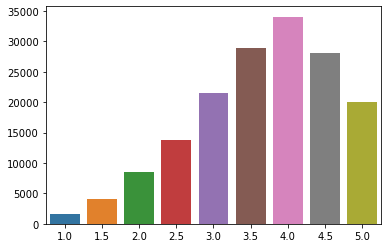

In [49]:
sns.barplot(value,count)